# Детекция объектов (VOC2012) Faster RCNN

## Импорт библиотек

In [1]:
# Для загрузки и анализа данных
import os
import tarfile
import urllib.request
import glob
import pandas as pd
import numpy as np
import xml.etree.ElementTree as ET
from tqdm import tqdm
from sklearn import preprocessing
from time import time

# Для работы с изображениями
import torchvision
from torchvision import transforms
import albumentations as alb
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader, Dataset
from torchvision.ops.boxes import nms
from PIL import Image

import cv2
import matplotlib.pyplot as plt
from IPython.display import display

# Для построения модели
import torch
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

## Загрузка данных

Будем использовать набор данных PASCAL Visual Object Classes ([VOC](http://host.robots.ox.ac.uk/pascal/VOC/index.html)), в котором присутствует 20 классов изображений.

Скачаем датасет и сохраним изображения 2010 года в cvs файл.

In [2]:
# Загрузка датасета
if not os.path.exists("VOCdevkit"):
    if not os.path.exists("VOC.tar"):
        urllib.request.urlretrieve(
            "http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar",
            "VOC.tar"
        )
    with tarfile.open("VOC.tar") as tar:
        tar.extractall()

Экспортируем информацию из аннотаций с помощью функции `xml_to_csv`.

In [3]:
def xml_to_csv(path = 'VOCdevkit/VOC2012/Annotations/'):
    xml_list = []
    for xml_file in tqdm(glob.glob(path + '/2010*.xml')):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for obj in root.findall('object'):
            bbx = obj.find('bndbox')
            xmin = int(bbx.find('xmin').text)
            ymin = int(bbx.find('ymin').text)
            xmax = int(bbx.find('xmax').text)
            ymax = int(bbx.find('ymax').text)
            label = obj.find('name').text

            value = (root.find('filename').text,
                     int(root.find('size')[0].text),
                     int(root.find('size')[1].text),
                     int(root.find('size')[2].text),
                     label,
                     xmin,
                     ymin,
                     xmax,
                     ymax
                     )
            xml_list.append(value)
    column_name = ['filename', 'channels', 'width', 'height',
                   'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df

Сохраним полученную информацию в VOC_2010.csv файл.

In [4]:
xml_df = xml_to_csv()
xml_df.to_csv('VOC_2010.csv', index=None)
print('Successfully converted xml to csv.')

100%|██████████| 3503/3503 [00:00<00:00, 14562.86it/s]

Successfully converted xml to csv.


In [5]:
xml_df.head()

,filename,channels,width,height,class,xmin,ymin,xmax,ymax
0,2010_006213.jpg,3,404,426,person,229,111,276,232
1,2010_003673.jpg,3,500,375,dog,27,204,375,500
2,2010_003673.jpg,3,500,375,person,1,65,219,500
3,2010_004431.jpg,3,333,500,sheep,143,91,354,276
4,2010_004431.jpg,3,333,500,bird,180,72,261,116


Отберем нужное нам количество сэмплов для упрощения обучения модели — опциональная функция.

In [6]:
xml_df_short = xml_df[:]

In [7]:
print(f'Общее количество объектов {xml_df_short.shape[0]}')
print(f'Количество изображений в датафрэйме {len(np.unique(xml_df_short["filename"]))}')

Общее количество объектов 7760
Количество изображений в датафрэйме 3503


## Обработка данных

Закодируем классы обьектов.

In [8]:
le = preprocessing.LabelEncoder()
xml_df_short['class_id'] = le.fit_transform(xml_df_short['class'])

<ipython-input-8-d4e2445dec86>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xml_df_short['class_id'] = le.fit_transform(xml_df_short['class'])


In [9]:
xml_df_short.head()

,filename,channels,width,height,class,xmin,ymin,xmax,ymax,class_id
0,2010_006213.jpg,3,404,426,person,229,111,276,232,14
1,2010_003673.jpg,3,500,375,dog,27,204,375,500,11
2,2010_003673.jpg,3,500,375,person,1,65,219,500,14
3,2010_004431.jpg,3,333,500,sheep,143,91,354,276,16
4,2010_004431.jpg,3,333,500,bird,180,72,261,116,2


In [10]:
zipped_labels_set = {*zip(xml_df_short['class_id'].values, xml_df_short['class'].values)}

labels_dict = dict(list(zipped_labels_set))
labels_dict

{13: 'motorbike',
 9: 'cow',
 10: 'diningtable',
 5: 'bus',
 1: 'bicycle',
 15: 'pottedplant',
 7: 'cat',
 2: 'bird',
 8: 'chair',
 17: 'sofa',
 19: 'tvmonitor',
 4: 'bottle',
 14: 'person',
 16: 'sheep',
 18: 'train',
 12: 'horse',
 11: 'dog',
 3: 'boat',
 0: 'aeroplane',
 6: 'car'}

Разделим выборку на train и val.

In [11]:
image_ids = xml_df_short['filename'].unique()
train_ids = image_ids[0:int(0.8*len(image_ids))]
val_ids = image_ids[int(0.8*len(image_ids)):]
print(f'# изображение {len(image_ids)}')
print(f'# train изображений {len(train_ids)}')
print(f'# val изображений {len(val_ids)}')

# изображение 3503
# train изображений 2802
# val изображений 701


In [12]:
train_df = xml_df_short[xml_df_short['filename'].isin(train_ids)]
val_df = xml_df_short[xml_df_short['filename'].isin(val_ids)]

Вспомогательная функция для аугментации данных.

In [13]:
def get_transforms(phase):
    list_transforms = []
    if phase == 'train':
        list_transforms.extend([alb.Flip(p=0.5)])
    list_transforms.extend([ToTensorV2(),])
    list_trms = alb.Compose(
        list_transforms,
        bbox_params={'format': 'pascal_voc', 'label_fields':['labels']}
    )

    return list_trms

Напишем класс `VOC_2010()` для загрузки данных в модель.

In [14]:
class VOC_2010(Dataset):
    def __init__(self, df, image_dir, phase='train'):
        super().__init__()
        self.df = df
        self.image_dir = image_dir
        self.images = df['filename'].unique()
        self.transforms = get_transforms(phase)


    def __len__(self):
        return len(self.images)

    def __getitem__(self,idx):
        image = self.images[idx]
        image_id = str(image.split('.')[0])

        image_arr = cv2.imread(os.path.join(self.image_dir, image), cv2.IMREAD_COLOR)
        image_arr = cv2.cvtColor(image_arr, cv2.COLOR_BGR2RGB).astype(np.float32)

        # Нормализация данных
        image_arr /= 255.0

        point = self.df[self.df['filename'] == image]
        boxes = point[['xmin', 'ymin', 'xmax', 'ymax']].values

        # Площадь внутри bbox
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)

        # Запишем класс объекта в переменную label
        labels = torch.as_tensor(point['class_id'].values, dtype=torch.int64)

        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor(idx)
        target['area'] = area

        if self.transforms:
            sample = {
                'image': image_arr,
                'bboxes': target['boxes'],
                'labels': target['labels']
            }
            sample = self.transforms(**sample)
            image = sample['image']

        target['boxes'] = torch.stack(tuple(map(torch.tensor,
                                                zip(*sample['bboxes'])))).permute(1, 0)

        return image, target, image_id


In [15]:
train_dir = 'VOCdevkit/VOC2012/JPEGImages/'

train_data = VOC_2010(train_df, train_dir, phase='train')
valid_data = VOC_2010(val_df, train_dir, phase='validation')

print(f'Размер обучающей выборки {len(train_data)}')
print(f'Размер валидационной выборки {len(valid_data)}')

Размер обучающей выборки 2802
Размер валидационной выборки 701


In [16]:
BATCH_SIZE = 4

def collate_fn(batch):
    return tuple(zip(*batch))

train_data_loader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_data,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn
)

Чтобы узнать, сколько батчей укладывается в треннировочном наборе данных, можно вывести длины соответствующий коллекций:

In [17]:
len(train_data_loader), len(train_data)

(701, 2802)

Аналогично с валидационной выборкой

In [18]:
len(valid_data_loader), len(valid_data)

(176, 701)

## Визуализация данных

In [19]:
def image_convert(image):
    image = image.clone().cpu().numpy()
    image = image.transpose((1,2,0))
    image = (image * 255).astype(np.uint8)
    return image

def plot_img(data,idx):
    img = data.__getitem__(idx)
    image = image_convert(img[0])
    image = np.ascontiguousarray(image)
    bbox = img[1]['boxes'].numpy()
    for box in bbox:
        cv2.rectangle(
            image, (int(box[0]), int(box[1])),
            (int(box[2]), int(box[3])), (0,255,0),
            thickness=2
        ),
        cv2.putText(
            image,
            f"{labels_dict[img[1]['labels'].item()]}",
            (int(box[0]), int(box[1])),
            cv2.FONT_HERSHEY_SIMPLEX, 0.5,
            (255, 0, 0), 2
        )
    plt.figure(figsize=(10,10))
    plt.imshow(image)

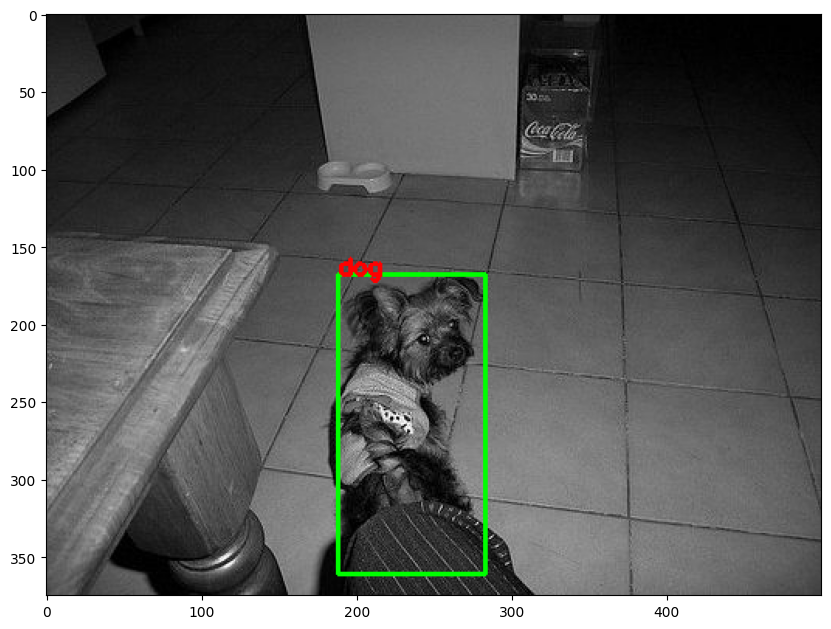

In [20]:
plot_img(train_data, 5)

Отрисуем 1 батч изображений с bbox.

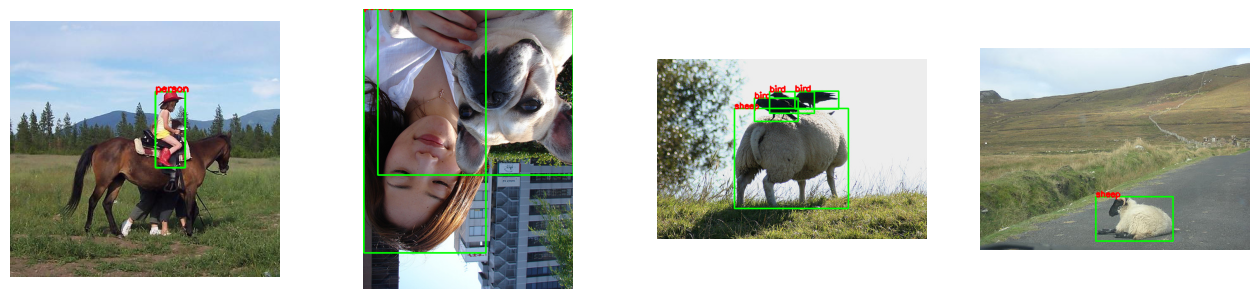

In [21]:
def plot_img_batch(data, batch_size=BATCH_SIZE):
    plt.figure(figsize=(16, 8))
    for i in range(batch_size):
        img = data.__getitem__(i)
        image = image_convert(img[0])
        label = img[1]
        image = np.ascontiguousarray(image)
        bbox = img[1]['boxes'].numpy()
        for j, box in enumerate(bbox):
            cv2.rectangle(
                image, (int(box[0]), int(box[1])),
                (int(box[2]), int(box[3])), (0, 255, 0),
                thickness=2
            ),
            cv2.putText(
                image,
                f"{labels_dict[img[1]['labels'][j].item()]}",
                (int(box[0]), int(box[1])),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                (255, 0, 0), 2
            )
        plt.subplot(2, 4, i+1)
        plt.imshow(image)
        plt.axis('off')

    plt.show()

plot_img_batch(train_data)

## Загрузка модели

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:', device)

Device: cuda


In [23]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='COCO_V1')

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 156MB/s]


In [24]:
num_classes = len(np.unique(xml_df['class']))
print(f'Число классов: {num_classes}')

# Получим число входных признаков для классификатора
in_features = model.roi_heads.box_predictor.cls_score.in_features

print(model.roi_heads)
# Заменим классификатор на новый
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
print(model.roi_heads)

Число классов: 20
RoIHeads(
  (box_roi_pool): MultiScaleRoIAlign(featmap_names=['0', '1', '2', '3'], output_size=(7, 7), sampling_ratio=2)
  (box_head): TwoMLPHead(
    (fc6): Linear(in_features=12544, out_features=1024, bias=True)
    (fc7): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (box_predictor): FastRCNNPredictor(
    (cls_score): Linear(in_features=1024, out_features=91, bias=True)
    (bbox_pred): Linear(in_features=1024, out_features=364, bias=True)
  )
)
RoIHeads(
  (box_roi_pool): MultiScaleRoIAlign(featmap_names=['0', '1', '2', '3'], output_size=(7, 7), sampling_ratio=2)
  (box_head): TwoMLPHead(
    (fc6): Linear(in_features=12544, out_features=1024, bias=True)
    (fc7): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (box_predictor): FastRCNNPredictor(
    (cls_score): Linear(in_features=1024, out_features=20, bias=True)
    (bbox_pred): Linear(in_features=1024, out_features=80, bias=True)
  )
)


In [25]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=1e-4, weight_decay=0.0005)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

Напишем функции для тренировки и валидации модели. Единственным отличием между ними будет отсутствие расчета градиента при валидации.Внутри функций мы переводим все данные внутри бача на устройство, на котором будут производится расчеты. Затем подаем полученные тензоры в модель и получаем словарь со значениями функций потерь. После этого посчитаем их сумму и для удобства запишем ее в переменную running_loss для отслеживания прогресса обучения. В конце каждой эпохи будем выводить среднее значение функций потерь.

In [26]:
def train(train_dataloader, rep_freq=10):
    model.train()
    running_loss = 0
    for i, data in enumerate(train_dataloader):
        optimizer.zero_grad()
        images, targets = data[0], data[1]
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        running_loss += losses.item()
        losses.backward()
        optimizer.step()
        if i % rep_freq == 0:
            print(f"\tИтерация #{i} losses: {losses}")
    train_loss = running_loss/len(train_dataloader.dataset)
    return train_loss

def val(valid_dataloader):
    running_loss = 0
    for data in valid_dataloader:
        optimizer.zero_grad()
        images, targets = data[0], data[1]
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        with torch.no_grad():
            loss_dict = model(images, targets)
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        running_loss += losses.item()
    val_loss = running_loss/len(valid_dataloader.dataset)
    return val_loss

## Обучение

Начинаем обучение.Создадим два списка, куда будем сохранять значения функций потерь после каждой эпохи на тренировке и валидации

In [27]:
NUM_EPOCHS = 5

train_losses = []
val_losses = []
try:
    for epoch in range(NUM_EPOCHS):
        start = time()
        train_loss = train(train_data_loader, rep_freq=50)
        val_loss = val(valid_data_loader)
        scheduler.step()
        print(f"Эпоха #{epoch} train_loss: {train_loss}, val_loss: {val_loss}")
        end = time()
        print(f"Потрачено {round((end - start) / 60, 1)} минут на {epoch} эпоху")
        train_losses.append(train_loss)
        val_losses.append(val_loss)
except KeyboardInterrupt:
    print('Прервано пользователем')

	Итерация #0 losses: 3.558272978637394
	Итерация #50 losses: 0.5719039800298782
	Итерация #100 losses: 0.22912726091640193
	Итерация #150 losses: 0.44161540094089463
	Итерация #200 losses: 0.44008839217749185
	Итерация #250 losses: 0.5543714101745275
	Итерация #300 losses: 0.2435697883482076
	Итерация #350 losses: 0.22353772003205646
	Итерация #400 losses: 0.25128767451771283
	Итерация #450 losses: 0.5630687537538267
	Итерация #500 losses: 0.28962589062243693
	Итерация #550 losses: 0.34574529335253257
	Итерация #600 losses: 0.34400451860728926
	Итерация #650 losses: 0.5817535361905732
	Итерация #700 losses: 0.2410046855677754
Эпоха #0 train_loss: 0.11626593659137296, val_loss: 0.09924572620117976
Потрачено 18.4 минут на 0 эпоху
	Итерация #0 losses: 0.35095112189972094
	Итерация #50 losses: 0.473734635824531
	Итерация #100 losses: 0.18723523161801578
	Итерация #150 losses: 0.4192330610263695
	Итерация #200 losses: 0.4170326945859026
	Итерация #250 losses: 0.3730949794360766
	Итерация #3

Визуализируем динамику лоссов

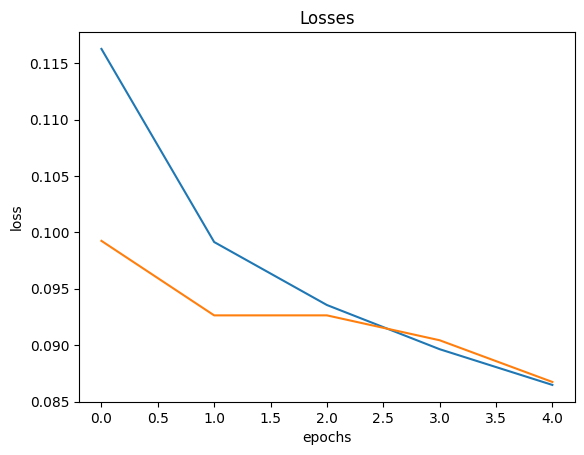

In [28]:
plt.title('Losses')
plt.plot(train_losses)
plt.plot(val_losses)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

Обучение заняло полтора часа, а лоссы, как видим, все падали.

## Предсказание

In [29]:
model.eval()

images, targets, ids = next(iter(valid_data_loader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

predictions = model(images)

In [30]:
def draw_predict(idx, iou_threshold=0.1, threshold=0.15):
    img = image_convert(images[idx])
    ind = nms(
        predictions[idx]['boxes'], predictions[idx]['scores'], iou_threshold
        ).detach().cpu().numpy()
    for i, box in enumerate(predictions[idx]['boxes'][ind]):
        if predictions[0]['scores'][i] > threshold:
            cv2.rectangle(img,
                (int(box[0]), int(box[1])),
                (int(box[2]), int(box[3])),
                (255, 0, 0), 2
                ),
            cv2.putText(img,
                f"{labels_dict[predictions[idx]['labels'][i].cpu().item()]} {predictions[idx]['scores'][i]:.2f}",
                (int(box[0]), int(box[1])),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                (255, 0, 0), 2
                )
    plt.imshow(img)
    plt.axis('off')

Выведем скоры, чтобы иметь представления о возможных значениях threshold:

In [31]:
[pred['scores'].max() for pred in predictions]

[tensor(0.5951, device='cuda:0', grad_fn=<MaxBackward1>),
 tensor(0.7972, device='cuda:0', grad_fn=<MaxBackward1>),
 tensor(0.9772, device='cuda:0', grad_fn=<MaxBackward1>),
 tensor(0.9697, device='cuda:0', grad_fn=<MaxBackward1>)]

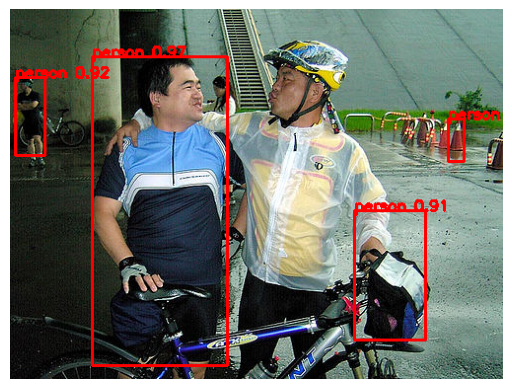

In [46]:
id = 3
draw_predict(id, iou_threshold=0, threshold=0.5)

Ну, по крайней мере, какие-то из людей на фото все же опознаны!

In [47]:
display(targets[id])
print(labels_dict[list(targets[id]['labels'])[0].item()])
print('-'*100)
display(predictions[id])
print(labels_dict[list(predictions[id]['labels'])[0].item()])

{'boxes': tensor([[  1.0000, 258.0000, 423.0000, 375.0000],
         [  6.0000,  99.0000,  79.0000, 141.0000],
         [ 84.0000,  45.0000, 241.0000, 375.0000],
         [ 95.0000,  33.0000, 389.0000, 375.0000],
         [  8.0000,  69.0000,  37.0000, 163.0000],
         [206.0000,  69.0000, 231.0000, 108.0000]], device='cuda:0',
        dtype=torch.float64),
 'labels': tensor([ 1,  1, 14, 14, 14, 14], device='cuda:0'),
 'image_id': tensor(3, device='cuda:0'),
 'area': tensor([ 49374.,   3066.,  51810., 100548.,   2726.,    975.], device='cuda:0')}

bicycle
----------------------------------------------------------------------------------------------------


{'boxes': tensor([[ 83.2000,  48.3603, 220.5312, 361.1959],
         [  5.1328,  69.8248,  35.4937, 148.8562],
         [349.7946, 204.3836, 421.8820, 335.7412],
         [200.6422,  47.3685, 380.7846, 337.3406],
         [105.8619,  41.1763, 345.1979, 359.1478],
         [202.5075,  69.2689, 231.2267, 109.6159],
         [444.9256, 111.8618, 460.3103, 154.2146],
         [ 96.0671,  62.1944, 235.9438, 240.4969],
         [194.6597,  68.6392, 238.3394, 124.3916],
         [ 42.6008, 107.4200,  78.1353, 138.0996],
         [188.1887,  57.2754, 333.8667, 218.8688],
         [ 39.1006, 105.3808,  75.3160, 141.3423],
         [197.6251,  58.5584, 236.0985, 169.7749],
         [177.2027,  56.8343, 233.9357, 114.3991],
         [484.0950, 129.3304, 499.7128, 162.4425],
         [ 99.4261,  56.0132, 287.3157, 167.3943],
         [302.7704, 140.4650, 422.9886, 355.6496],
         [ 12.1726, 106.2194,  75.7422, 142.3302],
         [269.6211,  53.0175, 382.2960, 260.6542],
         [ 87.3742, 18

person


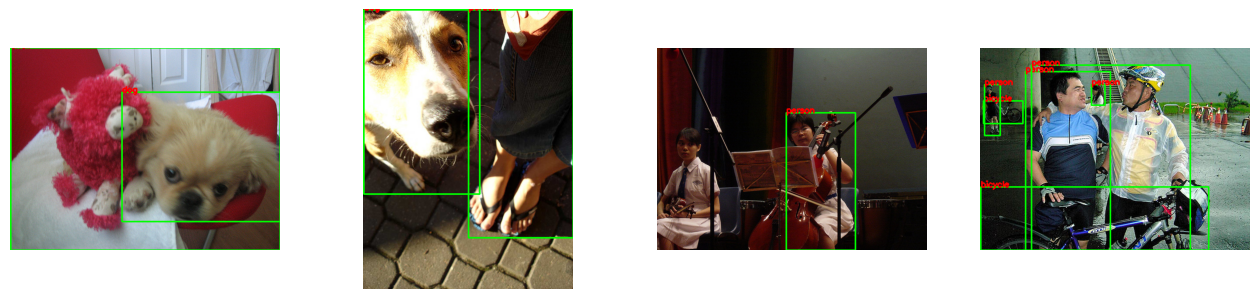

In [36]:
plot_img_batch(valid_data)